# Quality on YouTube Video Popularity
Author: Tim Chen  
03/25/2020

## Research Question
Over 720,000 hours of videos are uploaded to YouTube everyday in 2020. The notebook includes a simple regression analysis from end to end in an attempt to explore the relationship between a video's quality and its popularity on YouTube. In particular, we ask the following question: **How does the quality of a video affect its number of views?**  

Note that the regression analysis in this notebook does not attempt to establish a causal relationship of any kind due to the lack of a randomized experiment setup. The primary goal is to analyze the relationship between a video's quality and popularity on YouTube with the given features and records in the dataset. The focus is on performing an end-to-end regression analysis including EDA, modeling, and Gauss–Markov assumptions examination, and omitted variable bias analyses.    
  
## Dataset
The dataset consists of **9,489 randomly scraped videos across 17 categories** from YouTube in 2019. The data are compressed into a single csv file amd consists of the following features:
- Video ID
- Uploader Username  
- Age of Video  
- Category  
- Length of Video  
- Views  
- Viewer Rating  
- Number of Ratings  
- Number of Comments  

## Measurements
The operational definitions and relative metrics of the two primary concepts being researched, quality and popularity, are summarized as follows:  
- "**Quality**" is measured by the level of **viewer engagement** the video has attracted. In particular, our primary metric is the video's viewer rating, as specified by the `[rate]` variable in the dataset, although other variables such as the number of comments the video receives are also explored. Note that `[rate]` can be seen as ordinal (because the values of which are not truly continuous), but is assumed continuous throughout the analysis. The potential effect of the assumption is discussed in the conclusion at the end of the report.  
- "**Popularity**" is measured by the **number of views** a video receives. It is the outcome variable of our regression model.  

## Workflow  
The overall workflow is summarized by the flow diagram below. Note that the modeling phase includes a detailed validation on the model by examining the Gauss-Markov assumptions and potential omitted variable biases.  
  
<img src="https://www.dropbox.com/s/fmpz2ygk9s61hkw/workflow.png?raw=1" width="1100" />

## Data Cleanup
The following procedures are taken to clean up the data. A summary for the dataset after the cleanup (a total of 9,443 rows) is shown at the end.  

&nbsp; | Cleanup Procedure
------------:| :-------------
**NA's** | All NA rows are removed. no duplicate rows are found after the removal.  
**Constants** | The two constant columns, `[video_id]` and `[video_id]`, are removed.  
**`[Comments]`** | One row is found to have a negative value (-2) in `[comments]`. The negative value makes no logical sense as the smallest number of comments a video can have is zero. The row is assumed corrupted and removed. The removal should not have a notable effect on the analysis due to the dataset's large sample size (n=9480).
**`[Age]`** | There is a total of 36 videos with an age of zero day. Zero-age videos are removed because "quality" is operationally defined by `[rate]`, a variable that is meaningful only after a certain "age" on YouTube. A "zero rating" because of zero age on YouTube does not necessarily translate to "low in quality." The minimal age in the sample after the removal is 279 days, a value believed to be appropriate for the analysis.
**`[Category]`** | An indicator `[category_yng]` is added for the videos in categories believed to have relatively higher percentage of teenagers and young adults aged between 15 and 25. The goal with the new variable is to test if videos with young viewers behave differently. The categories included are: Entertainment, Film & Animation, Gaming, and Music.

In [22]:
library("car")
library("lmtest")
library("sandwich")
library("stargazer")
library("corrplot")
library("tidyverse")
library("data.table")
library("robustHD")
library("viridis")

In [23]:
YTubeDF = read.csv(file = 'data_ytb.csv',
                   header=TRUE, stringsAsFactors=FALSE, strip.white=TRUE)

# remove constant variables
YTubeDF$video_id = NULL
YTubeDF$uploader = NULL

# remove na rows
is.empty = function(df) apply(df, 2, function(col) col %in% "")
mask_na_empty = rowSums(is.na(YTubeDF) | is.empty(YTubeDF)) > 0
YTubeDF = YTubeDF[!mask_na_empty,]
                              
# -ve number of comment makes no sense; corruption assumed; removed
cat("Number of videos with -ve number of comments: ", nrow(YTubeDF[YTubeDF$comments < 0,]))
YTubeDF = YTubeDF[YTubeDF$comments >= 0,]

# remove zero-age videos
cat("\nNumber of zero-age videos: ", nrow(YTubeDF[YTubeDF$age == 0 ,]))
YTubeDF = YTubeDF[YTubeDF$age > 0,]
                              
# add indicator for the "young entertainment" category
category_yng = c("Entertainment", 
                 "Film & Animation", 
                 "Gaming",
                 "Music")
YTubeDF$category_yng = ifelse(YTubeDF$category %in% category_yng, 1, 0)

# summary
cat("\n\nDataset After Cleanup:\n")
str(YTubeDF)

Number of videos with -ve number of comments:  1
Number of zero-age videos:  36

Dataset After Cleanup:
'data.frame':	9443 obs. of  8 variables:
 $ age         : int  1131 1236 1243 1237 1252 1236 1053 1240 1237 1187 ...
 $ category    : chr  "Comedy" "Music" "Entertainment" "Entertainment" ...
 $ length      : int  126 243 105 278 26 252 162 37 166 139 ...
 $ views       : int  204 1652 898 928 392 318 749 10 115 617 ...
 $ rate        : num  3 3.91 4.48 5 1.5 5 3 0 2 4.67 ...
 $ ratings     : int  2 11 81 24 8 2 6 0 1 24 ...
 $ comments    : int  1 4 36 13 17 3 6 0 0 17 ...
 $ category_yng: num  0 1 1 1 0 1 0 1 1 0 ...


## Exploratory Data Analysis

### Summary
There are three key findings from EDA:
- Most variables come with a highly skewed distribution. In particular, `[views]`, `[ratings]`, and `[comments]` are skewed by both zeros and a small number of extreme outliers. Transformations will be considered for model building.
- Multiple variables are highly correlated, especially with the log transformation applied. The finding reinforces the idea that transformations should be explored for model building.
- An unexpected relationship between `[age]` and `[views]` is observed. Special attention is required for the two variables in model building.

### Zeros & Outliers
Histograms are plotted for all key variables for a high-level distribution analysis. Additional data summaries for `[views]`, `[ratings]`, and `[comments]` are included to highlight extreme outliers.

Almost all variables in the dataset are skewed by zeros and extreme outliers. For example, viewers tend to rate only the videos they like or dislike, resulting a high number of fives and zeros. `[views]`, `[ratings]`, and `[comments]`, in particular, show a strong "Michael Jordan" effect where there is one or a very small number of outliers skewing the entire distribution. Transformations will be considered.

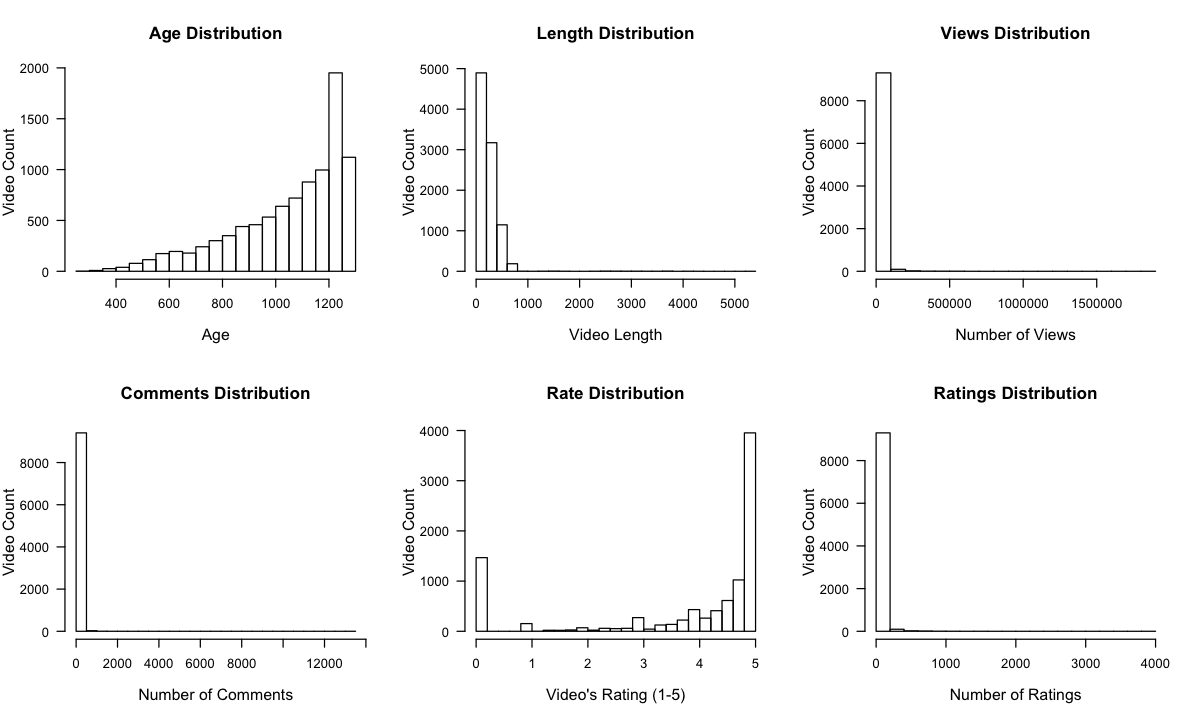

In [24]:
PLOT_CONFIG = list(cex.lab=1.2, cex.axis=1, cex.main=1.3, cex.sub=1, cex=0.7)
options(repr.plot.width=10, repr.plot.height=6)

par(las=1)
par(mfrow=c(2,3))
hist2 = function(df, title, xlab="", ylab="", breaks=20){
    hist(df, breaks = breaks, main=title, xlab=xlab, ylab=ylab,
         cex.lab=PLOT_CONFIG$cex.lab, cex.axis=PLOT_CONFIG$cex.axis, 
         cex.main=PLOT_CONFIG$cex.main, cex.sub=PLOT_CONFIG$cex.sub, cex=PLOT_CONFIG$cex)
}

hist2(YTubeDF$age, "Age Distribution", "Age", "Video Count")
hist2(YTubeDF$length, "Length Distribution", "Video Length", "Video Count")
hist2(YTubeDF$views, "Views Distribution", "Number of Views", "Video Count")
hist2(YTubeDF$comments, "Comments Distribution", "Number of Comments", "Video Count")
hist2(YTubeDF$rate, "Rate Distribution", "Video's Rating (1-5)", "Video Count")
hist2(YTubeDF$ratings, "Ratings Distribution", "Number of Ratings", "Video Count")

In [25]:
cat("Summary for [views]:")
summary(YTubeDF$views)

cat("\nSummary for [ratings]:")
summary(YTubeDF$ratings)

cat("\nSummary for [comments]:")
summary(YTubeDF$comments)

Summary for [views]:

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
      3.0     345.5    1441.0    9251.5    6098.5 1807640.0 


Summary for [ratings]:

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     1.0     5.0    20.3    15.0  3801.0 


Summary for [comments]:

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     1.00     3.00    19.42    13.00 13211.00 

### Joke Videos

In addition to outliers, `[ratings]`, and `[comments]` are also skewed by an overwhelming number of zeros, as shown by the histograms (after setting zero values equal to 0.1 and applying the log transformation). Intuition suggests that the "zero-value" videos are "joke" videos with contents quality so low that they attract zero engagement from viewers. These videos could behave differently from videos that do come with quality contents. Unfortunately, the dataset includes no additional variables for further investigations. 

Surprisingly, the distribution of `log(views)` is not skewed by joke videos, as shown by the "Log(Views) Distribution" histogram. One possible explanation is that YouTube's backend algorithm is efficient in identifying joke videos and preventing low-quality contents from showing up on viewers' recommendations and search results.

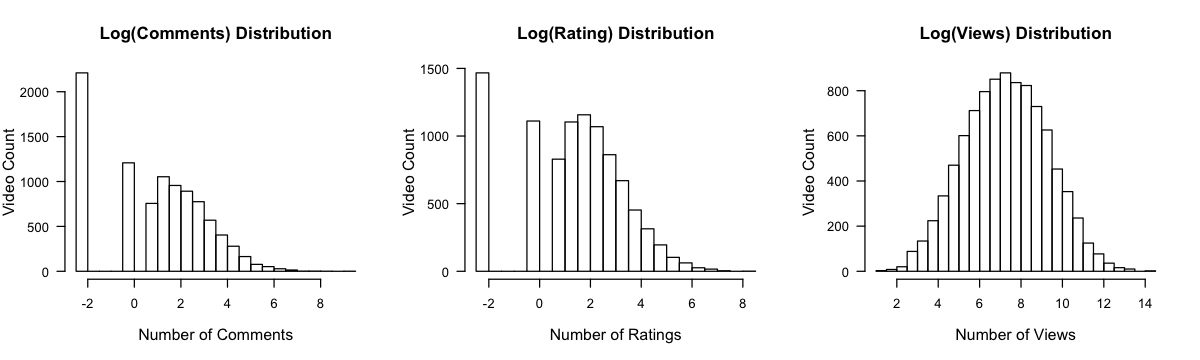

In [26]:
df = YTubeDF
df[df$comments == 0, "comments"] = 0.1
df[df$ratings == 0, "ratings"] = 0.1
df$views = log(df$views)
df$ratings = log(df$ratings)
df$comments = log(df$comments)

PLOT_CONFIG = list(cex.lab=1.2, cex.axis=1, cex.main=1.3, cex.sub=1, cex=0.7)
options(repr.plot.width=10, repr.plot.height=3)
par(las=1, mfrow=c(1,3))
hist2 = function(df, title, xlab="", ylab="", breaks=20){
    hist(df, breaks = breaks, main=title, xlab=xlab, ylab=ylab,
         cex.lab=PLOT_CONFIG$cex.lab, cex.axis=PLOT_CONFIG$cex.axis, 
         cex.main=PLOT_CONFIG$cex.main, cex.sub=PLOT_CONFIG$cex.sub, cex=PLOT_CONFIG$cex)
}

hist2(df$comments, "Log(Comments) Distribution", "Number of Comments", "Video Count")
hist2(df$ratings, "Log(Rating) Distribution", "Number of Ratings", "Video Count")
hist2(df$views, "Log(Views) Distribution", "Number of Views", "Video Count")

### Views vs. Age: A Rather Surprising Relationship
It is rather surprising to find a somewhat negative correlation between `[age]` and `[views]` because intuition suggests that the older videos have more time to attracts views on YouTube.

One possible explanation is that videos on YouTube are either "popular" or "dead":
- "Popular" videos tend to continue attracting views until a certain upper limit is reached. The upper bound can be either a "manipulated threshold" set up by YouTube's video ranking algorithm or a result of natural life cycle for the video's popularity.
- "Dead" videos, on the other hand, simply don't attract any significant amount of views no matter how long they live on YouTube.

Another important finding is that the variable, `[age]`, has a hard cutoff at 1,258 days, which could be a threshold artificially (or even wrongly) set up in the query. Investigations on i.i.d. are recommended unless the dataset can be confirmed to include all population data from YouTube (which is unlikely). 

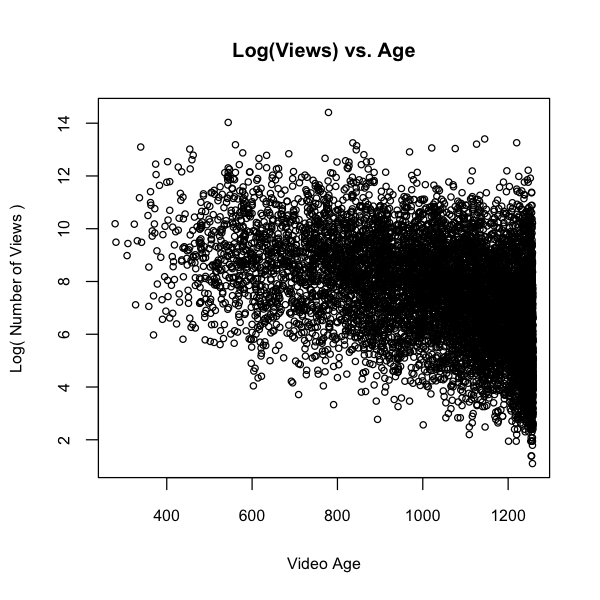

In [27]:
PLOT_CONFIG = list(cex.lab=0.8, cex.axis=0.8, cex.main=1, cex.sub=1, cex=0.7)
options(repr.plot.width=5, repr.plot.height=5)
plot(x=YTubeDF$age, y=log(YTubeDF$views), 
     main="Log(Views) vs. Age", xlab="Video Age", ylab="Log( Number of Views )",
     cex.lab=PLOT_CONFIG$cex.lab, cex.axis=PLOT_CONFIG$cex.axis, 
     cex.main=PLOT_CONFIG$cex.main, cex.sub=PLOT_CONFIG$cex.sub, cex=PLOT_CONFIG$cex)

### Correlation Analysis
Multiple variables are highly correlated with each other. The linear relationship is further bolstered after log transformation. There are at least two points of interest:

- `log[ratings]` has a particularly strong linear relationship with `[rate]`, `[comments]`, and `[views]`. The strong correlation reinforces the finding in "Zeros & Outliers" that viewers tend to engage only if they strongly like or dislike the video. 
- The unexpected negative correlation (with a coefficient of -0.48) between `log([views])` and `[age]` is discussed in the section, "Views vs. Age: A Rather Surprising Relationship."

Note that a small constant (0.1) is added to the zero values of `[comments]` and `[ratings]` in order to properly carry out the log transformation. The effect of which is discussed in details in the conclusion at the end of the report.

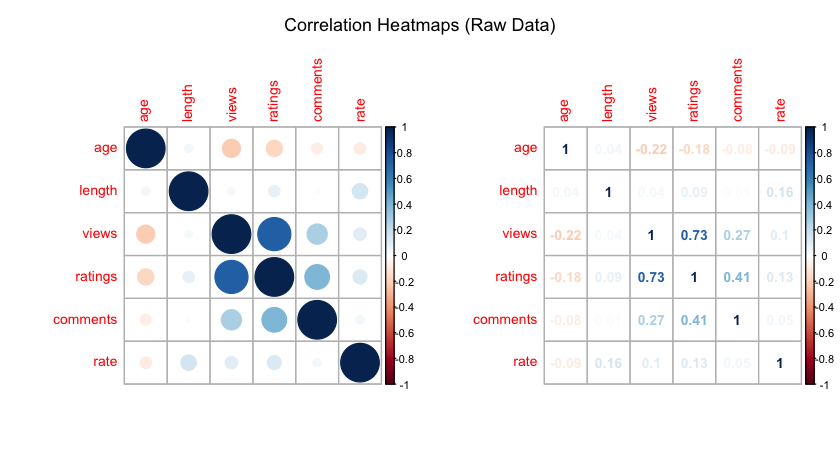

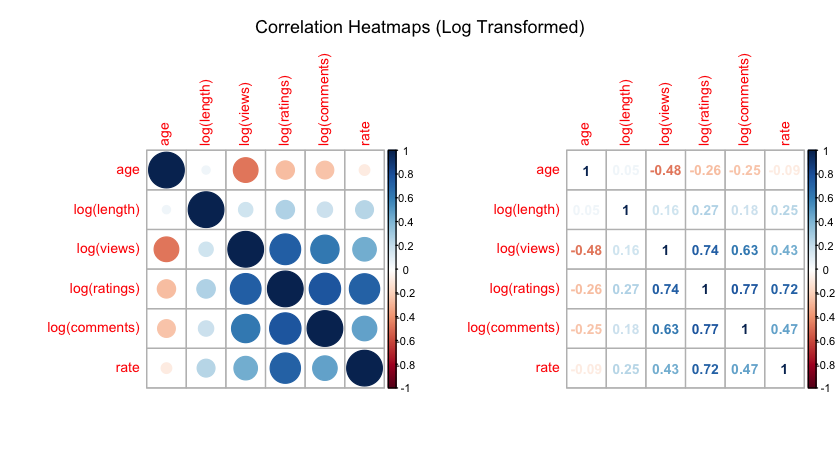

In [28]:
PLOT_CONFIG = list(cex.lab=0.8, cex.axis=0.8, cex.main=0.9, cex.sub=1, cex=0.7)
options(repr.plot.width=7, repr.plot.height=3.8)
par(mfrow=c(1,2))
par(cex = PLOT_CONFIG$cex)

# corr analysis on raw data
df = YTubeDF[, c("age", "length", "views", "ratings", "comments", "rate")]

cor_matrix = cor(df)
corrplot(cor_matrix, method = "circle")
corrplot(cor_matrix, method = "number")
mtext("Correlation Heatmaps (Raw Data)", side = 3, line = -2, 
      outer = TRUE, cex=PLOT_CONFIG$cex.main)

# log corr
df[df$comments == 0, "comments"] = 0.1
df[df$ratings == 0, "ratings"] = 0.1
df$length = log(df$length)
df$views = log(df$views)
df$ratings = log(df$ratings)
df$comments = log(df$comments)

cor_matrix = cor(df)
colnames(cor_matrix) = c("age", "log(length)", "log(views)", "log(ratings)", "log(comments)", "rate")
rownames(cor_matrix) = c("age", "log(length)", "log(views)", "log(ratings)", "log(comments)", "rate")
corrplot(cor_matrix, method = "circle")
corrplot(cor_matrix, method = "number")
mtext("Correlation Heatmaps (Log Transformed)", side = 1, line = -26, 
      outer = TRUE, cex=PLOT_CONFIG$cex.main)

### Young Audience Category

YouTube is known for attracting younger audience who behave differently from the older generations. The report aims to test the idea that videos watched mostly by young audience behave differently from the rest of the video population on YouTube. For the purpose of the analysis, The following categories are assumed to attract young audience aged between 15 and 25:
- Entertainment
- Film & Animation
- Gaming
- Music

A simple bar chart shows that "Entertainment", "Music", and "Film & Animation" are the top three categories by video count on YouTube, reinforcing the idea that YouTube tends to attract younger audience. A pie chart shows that roughly 61% of the data in our sample fall under the category of young audience, presenting a sufficient amount of data points for modeling.

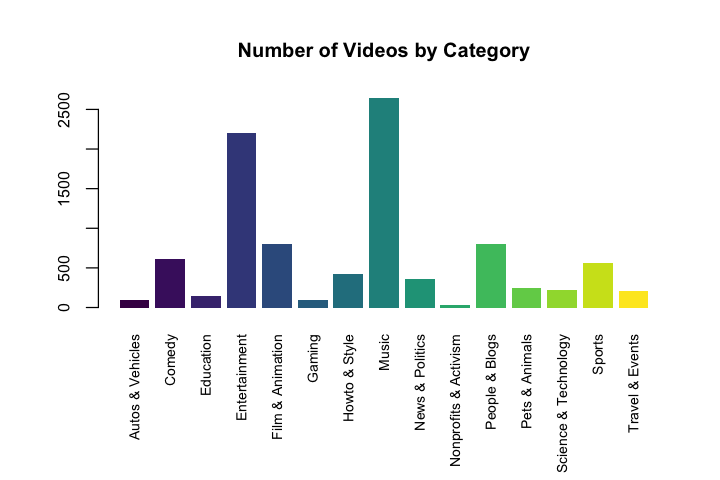

In [29]:
PLOT_CONFIG = list(cex.lab=0.8, cex.axis=0.8, cex.main=1, cex.sub=1, cex=0.7, 
                   color="D")
options(repr.plot.width=6, repr.plot.height=4)
par(las=3, mfrow=c(1,1), mar=c(7, 4, 4, 2) + 0.1)

data = factor(YTubeDF$category)
barplot(summary(data), main="Number of Videos by Category",
        col=viridis(n=nlevels(data), option=PLOT_CONFIG$color), border=FALSE,
        cex.lab=PLOT_CONFIG$cex.lab, cex.axis=PLOT_CONFIG$cex.axis,
        cex.main=PLOT_CONFIG$cex.main, cex.sub=PLOT_CONFIG$cex.sub, cex=PLOT_CONFIG$cex)

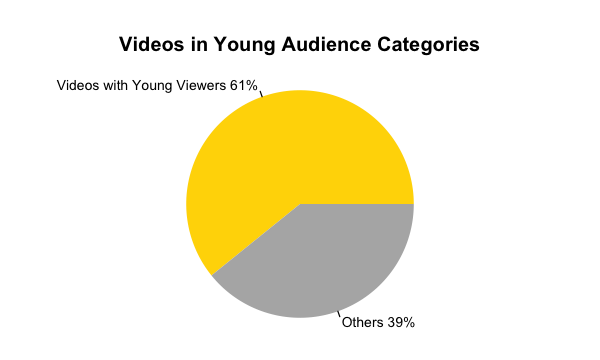

In [30]:
PLOT_CONFIG = list(cex.lab=0.8, cex.axis=0.8, cex.main=1, cex.sub=1, cex=0.7)
options(repr.plot.width=5, repr.plot.height=3)
par(las=3, mfrow=c(1,1), mar=c(0, 0, 2, 0) + 0.1)

count_yng = nrow(YTubeDF[YTubeDF$category_yng==1,])
count_others = nrow(YTubeDF[YTubeDF$category_yng==0,])
str_yng = paste0("Videos with Young Viewers ", round(count_yng / (count_yng + count_others) * 100), "%")
str_others = paste0("Others ", round(count_others / (count_yng + count_others) * 100), "%")

slices = c(nrow(YTubeDF[YTubeDF$category_yng==1,]), nrow(YTubeDF[YTubeDF$category_yng==0,]))
pie(slices,labels = c(str_yng, str_others),
    col=c("gold1","grey70"), border=FALSE,
    cex.lab=PLOT_CONFIG$cex.lab, cex.axis=PLOT_CONFIG$cex.axis, 
    cex.main=PLOT_CONFIG$cex.main, cex.sub=PLOT_CONFIG$cex.sub, cex=PLOT_CONFIG$cex)
title("Videos in Young Audience Categories", line=0, cex.main=PLOT_CONFIG$cex.main)

### Effects by Category

The six bar plots below provide a high-level overview of how category interacts with the different variables. The idea of exploring category as a dummy variable in model building is reinforced due to the following two observations:
- With the exception of `[rate]` and `[age]`, category does show significant practical effects across variables. 
- Young audience categories (Entertainment, Film & Animation, Gaming, and Music) seem to have a strong effect on `[views]`. In particular, Film & Animation receives a very strong viewership despite its relatively lower number of videos on YouTube.

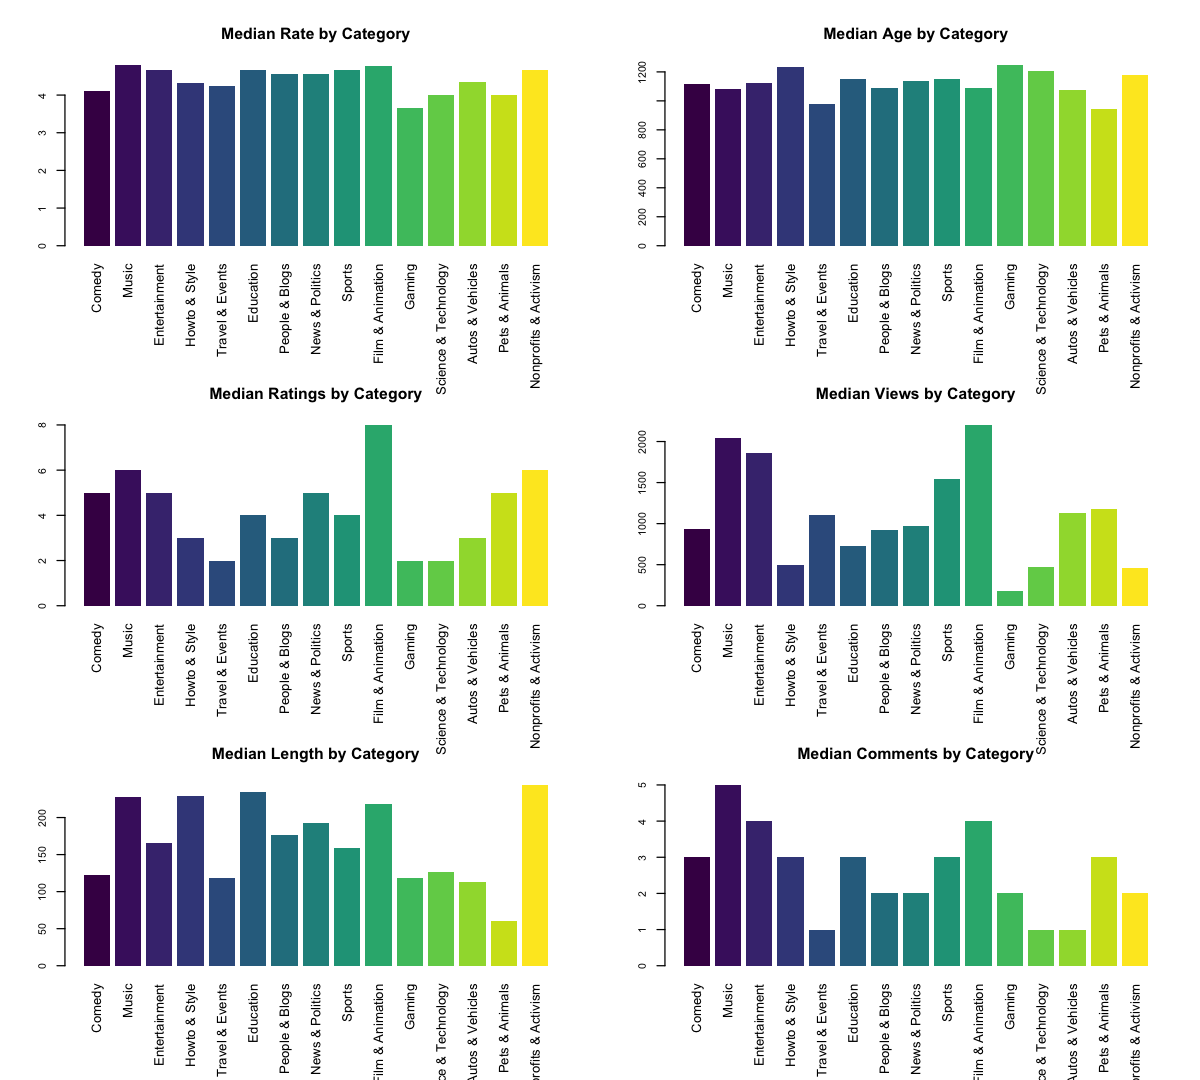

In [31]:
PLOT_CONFIG = list(cex.lab=0.8, cex.axis=0.8, cex.main=1.2, cex.sub=1, cex=1, 
                   color="D")
options(repr.plot.width=10, repr.plot.height=9)

df = YTubeDF[,c("category", "views", "rate", "age", "length", "ratings", "comments")]
dft = data.table(df)
dft = dft[, list(rate_m = round(median(rate), 2), 
                 views_m = round(median(views)),
                 age_m = round(median(age)),
                 length_m = round(median(length)),
                 ratings_m = round(median(ratings)), 
                 comments_m = round(median(comments))),
          by=category]

barplot2 = function(df, category, title){
    barplot(df, names.arg=category, main=title,
            col=viridis(n=nlevels(factor(category)), option=PLOT_CONFIG$color), border=FALSE,
            cex.lab=PLOT_CONFIG$cex.lab, cex.axis=PLOT_CONFIG$cex.axis, 
            cex.main=PLOT_CONFIG$cex.main, cex.sub=PLOT_CONFIG$cex.sub, cex=PLOT_CONFIG$cex)
}

par(las=3, mfrow=c(3,2), mar=c(7, 4, 4, 2) + 0.1)
barplot2(dft$rate_m, dft$category, "Median Rate by Category")
barplot2(dft$age_m, dft$category, "Median Age by Category")
barplot2(dft$ratings_m, dft$category, "Median Ratings by Category")
barplot2(dft$views_m, dft$category, "Median Views by Category")
barplot2(dft$length_m, dft$category, "Median Length by Category")
barplot2(dft$comments_m, dft$category, "Median Comments by Category")

## OLS Modeling

One OLS model is built to analyze the relationship between quality and viewership. A summary for the regression is included at the end of the section. 

- The interaction term, `log(ratings):category_yng`, is included for testing the assumption that videos with young audience behave differently on YouTube.

- Log transformation is applied for multiple variables based on the findings from EDA. The transformation greatly helps reduce the influence of outliers observed across the dataset, as demonstrated by the "Residuals vs. Leverage" plot. A few outliers after the transformation still possess high influence but all data points are well within Cook's distance.

- Note that a small constant (0.1) is added to the zero values of `[comments]` and `[ratings]` in order to properly carry out the log transformation. The effect of which is discussed in details in the conclusion at the end of the report.

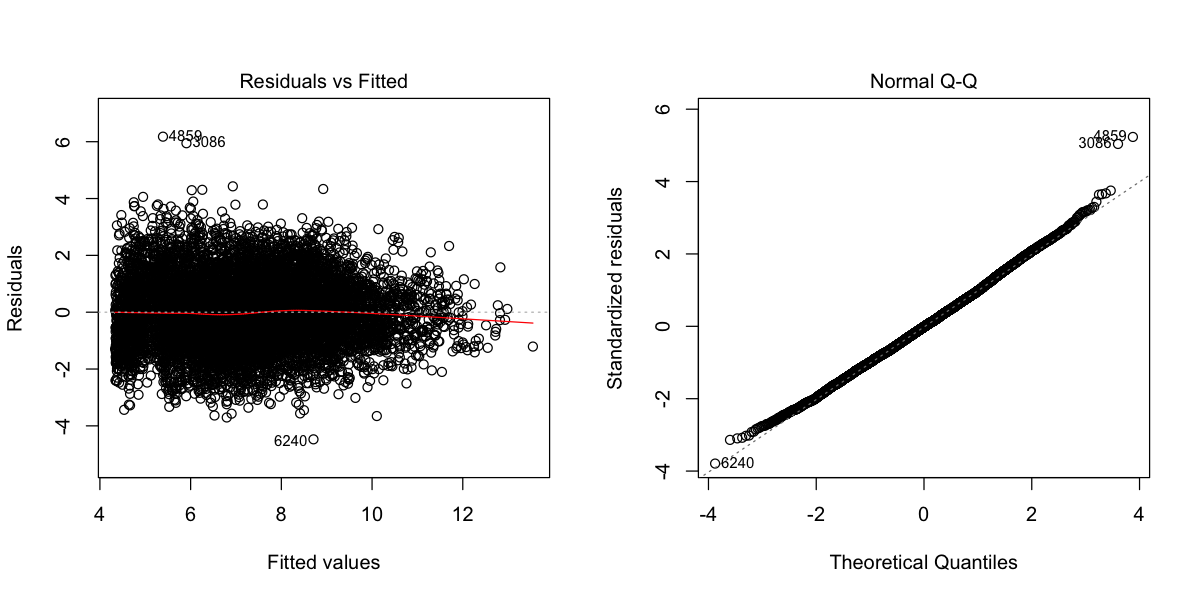

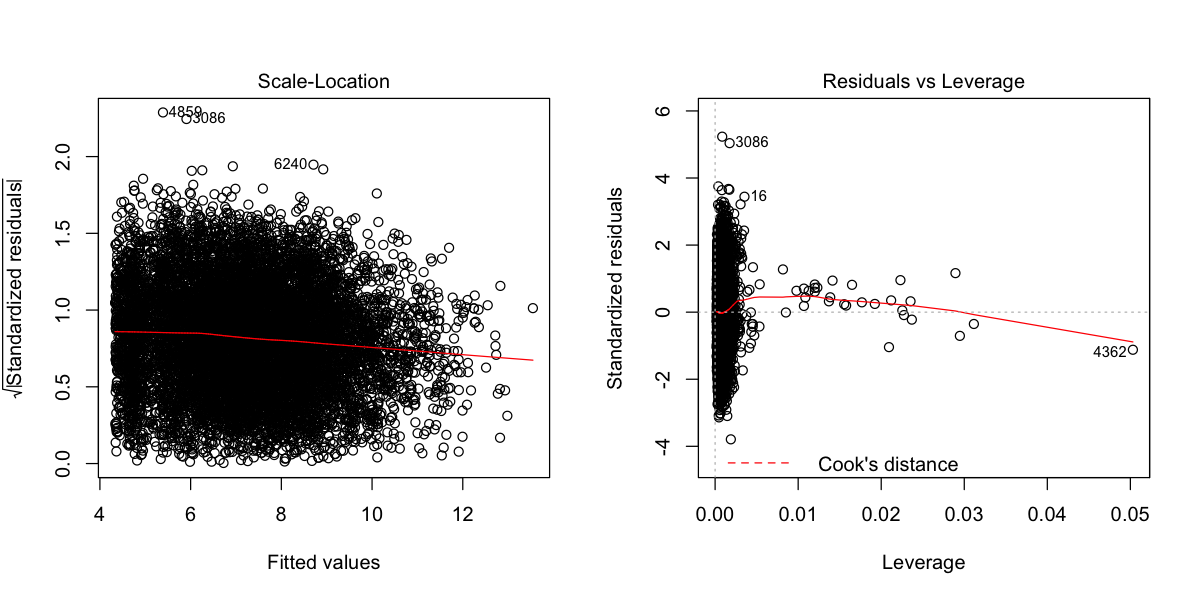

In [32]:
df = YTubeDF
df[df$comments == 0, "comments"] = 0.1
df[df$ratings == 0, "ratings"] = 0.1

# comment & rating are linear to each other; include only one
model = lm(log(views) ~ rate + age + length + log(comments) +
                        log(ratings) + category_yng + log(ratings)*category_yng, data=df)

# diagnosis plots
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
plot(model)

In [33]:
# Breusch-Pagan homoskedasticity test; null is homoskedasticity
bptest(model) 


	studentized Breusch-Pagan test

data:  model
BP = 255.34, df = 7, p-value < 2.2e-16


In [34]:
get_rubust_errors = function (lm) {
    return (coeftest(lm, vcov=vcovHC)[ , "Std. Error"])
}
model_robust_errors = get_rubust_errors(model)
stargazer(model,
          type = "text", 
          se = list(model_robust_errors))


                              Dependent variable:    
                          ---------------------------
                                  log(views)         
-----------------------------------------------------
rate                               -0.156***         
                                    (0.011)          
                                                     
age                                -0.003***         
                                   (0.0001)          
                                                     
length                             0.0003***         
                                   (0.00005)         
                                                     
log(comments)                      0.083***          
                                    (0.010)          
                                                     
log(ratings)                       0.671***          
                                    (0.017)          
                           

## CLM Assumptions

**Assumption MLR.1: Linear in Parameters**  
While whether the population parameters are truly linear to each other is unknown, the test results and residual plots show evidence that the linear model built in this report is a reasonable estimate for the population.

**Assumption MLR.2: Random Sampling**  
Random Sampling cannot be verified without details on how the data was collected. There is a possibility of clustering due to the unexpected upper bound limit of the `[age]` variable at 1,258 days.  

We assume Random Sampling for the scope of the analysis. However, further investigations on the data collection methodology are recommended before conclusions can
be finalized.

**Assumption MLR.3: No Perfect Collinearity**  
There is no evidence for perfect collinearity despite the fact that multiple variables are highly correlated to each other. The assumption is satisfied. 

**Assumption MLR.4: Zero Conditional Mean**  
The “Residuals vs. Fitted” plot shows that the residuals roughly have a mean of zero, especially in areas where there is a sufficient amount of data points. The assumption of zero conditional mean is reasonably satisfied.

**Assumption MLR.4': Exogeneity**  
No linear relationship is observed in the “Residuals vs. Fitted” plot, which is a positive signal for endogeneity. However, omitted variable bias cannot be verified using residual plots and a detailed analysis of possible omitted variable biases are included in the Omitted Variables section.

**Assumption MLR.5: Homoskedasticity**  
Both the Scale-Location plot and the Breusch-Pagan test confirm heteroskedasticity. Robust errors are used for the model.

**Assumption MLR.6 Normality**  
With the exception for a few outliers, the q-q plot shows a reasonable straight line, which indicates normality. CLT applies because of the large sample size (9443 observations).

## Model Significance
Except for the interaction term `[log(ratings):category_yng]`, all estimators are statistically significant using the robust errors. The overall model also comes with a highly significant F-value. 

Of all the coefficients, `category_yng`, `log(ratings)`, and `rate` come with meaningful practical significance. `log(comments)` is somewhat practically significant while `length` and `age` are practically insignificant comparing to other variables.

## Omitted Variables
Three omitted variables have been identified. Note that `[log(ratings):category_yng]` is excluded from the discussion due to its lack of statistical significance.

### Number of Subscribers (to the Uploader's Channel)
**Assumptions:**
- No correlation with `age`, `length`, and `comments`
- Positive correlation with:
    - `rate` (assuming channels with higher number of subscribers know how to better produce videos viewers enjoy)
    - `ratings` (assuming viewers are more likely to rate videos from channels they subscribe to)
    - `category_yng` (assuming young viewers are more likely to subscribe to channels from young-audience categories)
- Strong positive partial correlation with `views` (assuming subscribers are a lot more likely to watch videos from their subscribed channels)

**Estimator Biases:**
- No Bias: `age`, `length`, `comments`
- Positive Bias, Towards Zero: `rate`
- Positive Bias, Away from Zero: `ratings`, `category_yng`

### Number of Shares
**Assumptions:**
- No correlation with `age` and `length`
- Positive correlation with:
    - `rate` (assuming viewers enjoy sharing the videos they rate high)
    - `comments` (assuming viewers who share are more likely to also engage in discussions)
    - `ratings` (assuming viewers tend to share the videos that they care enough to rate)
    - `category_yng` (assuming young viewers are more likely to share videos from young-audience categories)
- Strong positive partial correlation with `views` (assuming shared videos reach more viewers)

**Estimator Biases:**
- No Bias: `age`, `length`
- Positive Bias, Towards Zero: `rate`
- Positive Bias, Away from Zero: `comments`, `ratings`, `category_yng`

### Number of Saves (to Viewers' Personal Play Lists on YouTube)
**Assumptions:**
- No correlation with `age`, `length`, `comments`, and `category_yng`
- Positive correlation with:
    - `rate` (assuming viewers tend to save the videos they rate high)
    - `ratings` (assuming viewers who save the video usually care enough to also submit a rating)
- Strong positive partial correlation with `views` (assuming viewers repeatedly watch their saved videos)

**Estimator Biases:**
- No Bias: `age`, `length`, `comments`, `category_yng`
- Positive Bias, Towards Zero: `rate`
- Positive Bias, Away from Zero: `ratings`

## Conclusion

**Quality**  
"Quality," proxied by `[rate]` in the analysis, does have an statistical and practical effect on the number of views received by videos. However, quality is surprisingly negatively related to views with a coefficient estimator of -0.156 when all other variables are controlled for. One unit of change in quality, or `[rate]`, would lead to a roughly -0.156% change in views. The relationship makes no logical sense but could be explained by:

- The results are highly skewed by the 1,467 videos that are rated zero because they receive zero number of rating. The skew is further bolstered when setting zeros to 0.1 before applying the log transformation. While the appropriateness of log transformation by adding a constant to zeros can be questioned, the more important questions are why there is an overwhelmingly high number of videos that come with zero rating, and how they behave differently from the rest of the videos on YouTube. Unfortunately the dataset given does not contain relevant variables required for the investigation. 

- Although aggregated as a continuous variable in the dataset,`[rate]` is really an ordinal scale with five possible values: 1, 2, 3, 4, and 5. The ordinal nature of `[rate]` is evident in the "Rate: Ordinal or Numerical?" scatter plot below. A different method to aggregate `[rate]` should be explored. 

**Ratings & Category**  
The number of ratings and young-audience category also have significant statistical and practical effects on views. The relationship between ratings and views is particular strong but rather unsurprising because logically the chance of receiving ratings should be higher as the video is watched by more viewers. YouTube is also known to attract younger audience so videos in young-audience categories would naturally tend to attract a high number of views. The interaction term `log(ratings):category_yng ` is unfortunately statistically insignificant so no conclusive inference can be made about the interaction.

**Age**  
Lastly, another important and yet surprising association observed is between the ages and views of videos. The negative correlation between the two variables is discussed in details in the "Views vs. Age: A Rather Surprising Relationship" section. The new unexpected finding, however, is the insignificant practical effect observed when other variables are controlled for. Intuitively speaking, with all else equal (especially when `[rate]` is held constant), older videos on YouTube should have more time to attract a higher number of views. The report is unable to offer a plausible explanation with the dataset given, but a deep dive on the topic is highly recommended.

**Risk**  
In sum, all inferences made in the report are unfortunately questionable until the issue of `[rate]` (i.e. ordinal vs. numerical) is resolved.

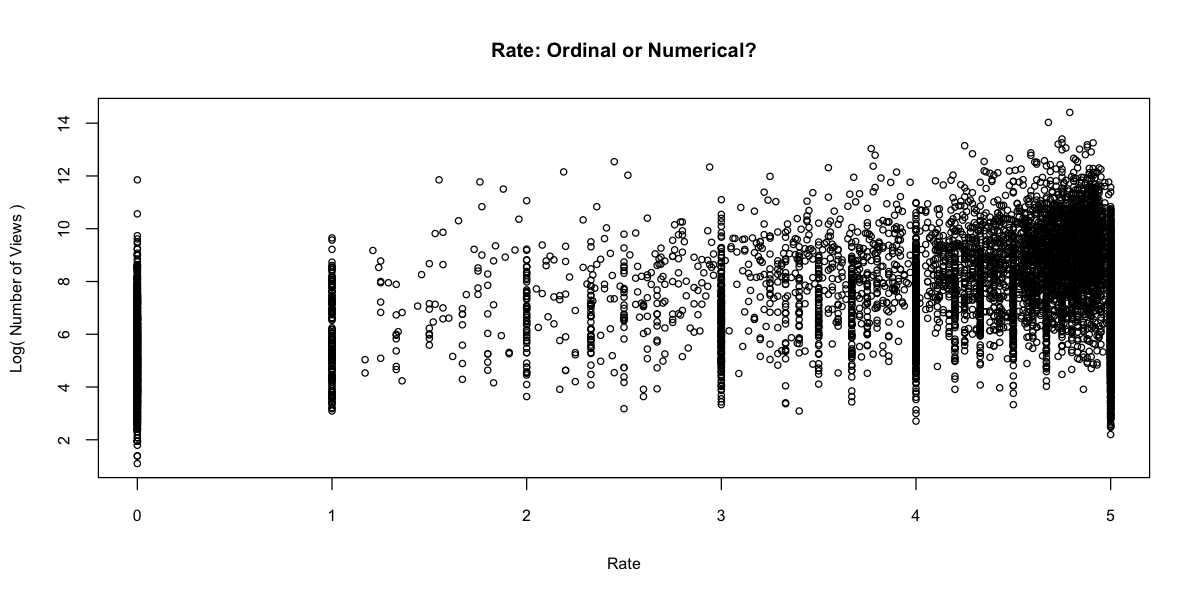

In [35]:
PLOT_CONFIG = list(cex.lab=0.8, cex.axis=0.8, cex.main=1, cex.sub=1, cex=0.7)
options(repr.plot.width=10, repr.plot.height=5)
plot(x=YTubeDF$rate, y=log(YTubeDF$views), 
     main="Rate: Ordinal or Numerical?", xlab="Rate", ylab="Log( Number of Views )",
     cex.lab=PLOT_CONFIG$cex.lab, cex.axis=PLOT_CONFIG$cex.axis, 
     cex.main=PLOT_CONFIG$cex.main, cex.sub=PLOT_CONFIG$cex.sub, cex=PLOT_CONFIG$cex)